The energy output from a quasar is very different from that of a star, both in intensity and frequency dependence. A bright quasar has energy output of $4 \times 10^{39}\,\mathrm{W}$, and resides in the centre of a galaxy of radius $3 \times 10^{20}\,\mathrm{m}$, (or $30000$ light years).

The frequency dependence of the quasar luminosity at frequencies $\nu \geq \nu_0$ is given by
\begin{equation}
    L_\nu = 10^{24}\left(\frac{\nu}{\nu_0}\right)^{-1.4} \exp \left( -\frac{\nu}{10\nu_0}\right),
\end{equation}
We assume that the gas temperature is $10^4\,\mathrm{K}$, and the density is $10^6$ hydrogen atoms per cubic metre. Also, we assume also that there is no gas within $10^{18}\,\mathrm{m}$ of the quasar position.



Distance (light yrs) | Neutral Fraction    
---------------------------------------------
106                  | 1.0210e-11
198                  | 3.5770e-11
374                  | 1.2784e-10
707                  | 4.5687e-10
1323                 | 1.6006e-09
2502                 | 5.7205e-09
4730                 | 2.0447e-08
8853                 | 7.1694e-08
16736                | 2.5770e-07
31638                | 9.5814e-07


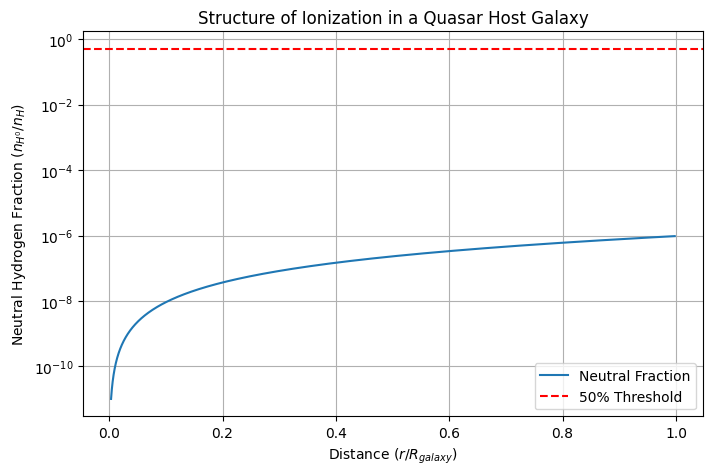

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
h = 6.626e-34
c = 3.0e8
k_B = 1.38e-23
pc = 3.086e16       # Parsec in meters
nu_0 = 3.29e15      # Ionization threshold (Hz)
a_0 = 6.3e-22       # Cross-section at threshold (m^2)

class QuasarSolver:
    def __init__(self, n_H, T_gas=10000):
        self.n_H = n_H
        self.alpha_B = 2.59e-19  # Recombination coeff for 10,000K

    def quasar_luminosity(self, nu):
        """
        L_nu = 10^24 * (nu/nu_0)^(-1.4) * exp(-nu / 10nu_0)
        """
        ratio = nu / nu_0
        # Use simple formula provided
        return 1e24 * (ratio)**(-1.4) * np.exp(-ratio / 10.0)

    def solve(self, r_start, r_end, num_freq_bins=200):
        # 1. Setup Frequency Grid
        # Integrate up to 50*nu_0 to capture the high energy tail
        nu_max = 50 * nu_0
        nus = np.linspace(nu_0, nu_max, num_freq_bins)
        dnu = nus[1] - nus[0]

        # Pre-calculate cross-sections and source luminosity terms
        sigma_nu = a_0 * (nu_0 / nus)**3
        L_nu_vals = self.quasar_luminosity(nus)
        integrand_base = (L_nu_vals / (h * nus)) * sigma_nu

        # 2. Simulation Loop
        r = r_start
        tau_current = 0.0

        r_list = []
        neutral_frac_list = []

        while r < r_end:
            # A. Calculate Gamma (Ionization Rate)
            # Optical depth at frequency nu scales as (nu_0/nu)^3
            tau_nu_array = tau_current * (nu_0 / nus)**3
            attenuation = np.exp(-tau_nu_array)

            integral_val = np.sum(integrand_base * attenuation) * dnu
            Gamma = (1.0 / (4 * np.pi * r**2)) * integral_val

            # B. Solve for Neutral Fraction (y) Robustly
            # The equilibrium equation is: (1-y)^2 / y = RHS
            # where RHS = Gamma / (n_H * alpha_B)
            # This rearranges to: y^2 - (2 + RHS)y + 1 = 0
            # For large RHS, the standard quadratic formula loses precision.
            # We use the stable form: y = 2c / (-b + sqrt(b^2 - 4ac))

            RHS = Gamma / (self.n_H * self.alpha_B)

            # Coefficients for ay^2 + by + c = 0
            # a=1, b=-(2+RHS), c=1
            b_term = -(2.0 + RHS)
            discriminant = b_term**2 - 4.0

            # Stable solution for the small root (neutral fraction)
            # y = 2 / ((2+RHS) + sqrt((2+RHS)^2 - 4))
            denom = (2.0 + RHS) + np.sqrt(discriminant)
            neutral_frac = 2.0 / denom

            # Store Data
            r_list.append(r)
            neutral_frac_list.append(neutral_frac)

            # C. Determine Adaptive Step Size
            # Opacity = n_H * neutral_frac * a_0
            opacity = self.n_H * neutral_frac * a_0

            # Prevent division by zero if opacity is extremely low
            if opacity < 1e-30:
                dr_optical = 1e30 # Huge step allowed optically
            else:
                dr_optical = 0.1 / opacity

            # Geometric limit (1% of current radius)
            dr_geom = 0.01 * r

            # Take the smaller safe step
            dr = min(dr_optical, dr_geom)

            # Boundary checks
            if r + dr > r_end:
                dr = r_end - r

            # Update state
            dtau = opacity * dr
            tau_current += dtau
            r += dr

            # Stop if we are close enough to end
            if (r_end - r) < 1e14:
                break

        return np.array(r_list), np.array(neutral_frac_list)

# --- EXECUTION ---
solver = QuasarSolver(n_H=1e6)
r_start = 1e18       # Start at 10^18 m
r_end = 3e20         # End at 3*10^20 m (Galaxy edge)

r_vals, neutral_vals = solver.solve(r_start, r_end)

# --- DATA OUTPUT ---
print(f"\n{'Distance (light yrs)':<20} | {'Neutral Fraction':<20}")
print("-" * 45)

# Pick 10 evenly spaced indices to show the trend
indices = np.linspace(0, len(r_vals)-1, 10, dtype=int)
ly = 9.461e15 # meters per light year

for i in indices:
    d_ly = r_vals[i] / ly
    nf = neutral_vals[i]
    print(f"{d_ly:<20.0f} | {nf:.4e}")

plt.figure(figsize=(8, 5))
plt.plot(r_vals / r_end, neutral_vals, label='Neutral Fraction')
plt.axhline(0.5, color='red', linestyle='--', label='50% Threshold')
plt.yscale('log')
plt.xlabel('Distance ($r / R_{galaxy}$)')
plt.ylabel('Neutral Hydrogen Fraction ($n_{H^0}/n_H$)')
plt.title('Structure of Ionization in a Quasar Host Galaxy')
plt.legend()
plt.grid(True)
plt.show()

Even at the very edge of the galaxy, the neutral fraction is almost negligible. The gas remains predominantly ionised throughout the entire galaxy. This is due to the immense luminosity of the quasar. The Stroemgren radius for this quasar is larger than the galaxy itself. Consequently, the entire galaxy resides inside the ionised zone.

The quasar has a luminosity of approximately $4 \times 10^{39}\,\mathrm{W}$. The average ionising photon energy is roughly $20-30\,\mathrm{eV} \approx 4 \times 10^{-18}\,\mathrm{J}$, so the total ionising particles per second is approximately $Q \approx 10^{57}$ and the radius is
\begin{equation}
    R_S = \left( \frac{3Q}{4\pi n_H^2 \alpha_B} \right)^{1/3} \approx 10^{21}\,\mathrm{m}.
\end{equation}
In comparison, the galaxy radius is $3 \times 10^{20}\,\mathrm{M}$.

Deep inside the ionised zone (where the gas is transparent), the neutral fraction $x_{neutral}$ is governed by simple geometric dilution of the light. It should increase proportional to distance squared or as $r^2$, which is evident from our results.

This result shows that the quasar is so powerful compared to a star that it completely bleaches the galaxy. The radiation is so intense that hydrogen atoms are stripped of electrons almost instantly, keeping the neutral fraction very low, even at the edge of the galaxy.